In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=33dc132ed55f2ef9a0cb97790f38a9eb592699adb75fd8a1bb8ffe9d70dfe4eb
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import os
import re
import tqdm
import string
import unicodedata
import collections
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup  

import re

import nltk
from nltk.corpus import stopwords, wordnet 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer

from collections import defaultdict

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from bayes_opt import BayesianOptimization

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

In [ ]:
nltk.download("stopwords")
stop_words = stopwords.words('english')
seed = 78
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/amazon reviews/train.csv')
train.head()
#print(f'Train shape: {train.shape}')
#- Test shape: {test.shape}'

,polarity,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [ ]:
text = train['text']
text.count()

1048575

# Data Exploration

In [ ]:
print("Summary statistics of numerical features : \n", train.describe())

print("\nTotal number of reviews: ",len(train))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(train[train['polarity']==3]["text"].count()/len(train)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(train[train['polarity']==1]["text"].count()/len(train)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(train[train['polarity']==2]["text"].count()/len(train)*100))

Summary statistics of numerical features : 
            polarity
count  1.048575e+06
mean   1.505600e+00
std    4.999689e-01
min    1.000000e+00
25%    1.000000e+00
50%    2.000000e+00
75%    2.000000e+00
max    2.000000e+00

Total number of reviews:  1048575

Percentage of reviews with neutral sentiment : 0.00%

Percentage of reviews with positive sentiment : 49.44%

Percentage of reviews with negative sentiment : 50.56%


# Data Visualization

Text(0, 0.5, 'Count')

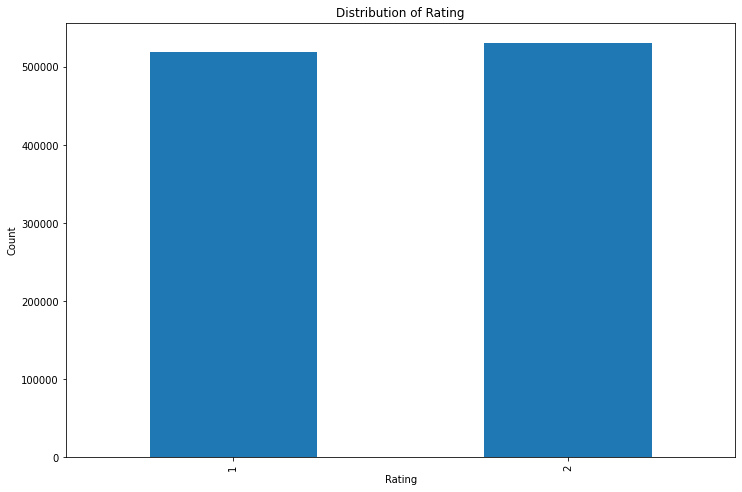

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
train['polarity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

# Data Preparation

In [ ]:
train = train.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
#train.dropna(inplace=True)

# Encode 2s as 1 (positive sentiment) and 1s as 0 (negative sentiment)
train['Sentiment'] = np.where(train['polarity']==1, 0, 1)
train.head()

,polarity,title,text,Sentiment
875680,2,We LOVE Night Catch!!,We bought this book so I could video tape my h...,1
1046906,1,RIDICULOUSLY priced!,"You can get it for $24.95 + tax from ULC, and ...",0
646861,1,Waste of money and did not last 2 years! RUNNN...,I bought this printer less than two years ago....,0
704385,1,Not the best,After reading 13 sequels to POTO this is one o...,0
798051,1,Huh? Who? How? What Happened?,This movie could have gone down in history as ...,0


# Train Test Split

In [ ]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(train.text, train.Sentiment, random_state=0)
#train_test_split(train['text'], train['Sentiment'], test_size=0.25, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 78643 training examples and 26215 validation examples. 

Show a review in the training set : 
 I have an old LP album of the same title as this Cd and with the same photo of Fats on the cover that I consider excellant. I thought this Cd was that album but its not- not even close. Very disapointing.


# Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier to do feature extraction in the next step.

*   remove html tags using BeautifulSoup
*   remove non-character such as digits and symbols
*   convert to lower case
*   remove stop words such as "the" and "and" if needed
*   convert to root words by stemming if needed

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 i have an old lp album of the same title as this cd and with the same photo of fats on the cover that i consider excellant i thought this cd was that album but its not not even close very disapointing


# Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Create volcabulary list using Word2Vec model
* Transform each review into numerical representation by computing average feature vectors of words therein
* Fit the average feature vectors to Random Forest Classifier



In [ ]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
78643 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['i', 'have', 'an', 'old', 'lp', 'album', 'of', 'the', 'same', 'title', 'as', 'this', 'cd', 'and', 'with', 'the', 'same', 'photo', 'of', 'fats', 'on', 'the', 'cover', 'that', 'i', 'consider', 'excellant', 'i', 'thought', 'this', 'cd', 'was', 'that', 'album', 'but', 'its', 'not', 'not', 'even', 'close', 'very', 'disapointing']


In [ ]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 17456 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'and', 'a', 'to', 'it', 'of', 'this', 'is', 'in']


In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 78643 feature vectors with 300 dimensions
Validation set : 26215 feature vectors with 300 dimensions


# LSTM
Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative sentiment using Keras libarary.
### Simple LSTM 

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.
Here's the workflow in this part.

* Prepare X_train and X_test to 2D tensor
* Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape)
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (78643, 100)
X_test shape: (26215, 100)
y_train shape: (78643, 2)
y_test shape: (26215, 2)


In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128, dropout=0.2))
model1.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

TypeError: ignored

In [ ]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) # weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) # weight dim of dense layer

# LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account. The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to intialize the weights of embedding layer in LSTM.

* Load pretrained word embedding model
* Construct embedding layer using embedding matrix as weights
* Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (17456, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)
print('X_test shape:', X_test_seq.shape)
print('y_train shape:', y_train_seq.shape)
print('y_test shape:', y_test_seq.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (78643, 100)
X_test shape: (26215, 100)
y_train shape: (78643, 2)
y_test shape: (26215, 2)


In [ ]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(units=128)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=3, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         5236800   
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
Total params: 5,456,706
Trainable params: 5,456,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2458/2458 [==============================] - 837s 339ms/step - loss: 0.3560 - accuracy: 0.8448
Epoch 2/3
2458/2458 [==============================] - 834s 339ms/step 

In [ ]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) # weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) # weight dim of dense layer

Size of weight matrix in the embedding layer :  (17456, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)
